In [1]:
import scipy.io as spy
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, GRU, BatchNormalization
from keras.optimizers import Adam 
import os 
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf  
os.environ["CUDA_VISIBLE_DEVICES"] ="0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# Now when creating your session pass this config to it.
sess = tf.Session(config=config)
def get_data():
    data = spy.loadmat('03-28-17_12.51 10degC_Cycle_1_Pan18650PF.mat')
    cur = data['meas'][0][0][2].tolist()
    ah = data['meas'][0][0][3].tolist()
    time = data['meas'][0][0][7].tolist()
    return cur, ah, time

def get_traindata(cur, ah, time, timestep,SOC_INIT):
    cur_data = []
    ah_data = []
    time_data = []
    soc_data = []

    x = []
    y = []

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    flag = 0
    for i in range(len(cur)):
        cur_data.append(cur[i][0])
        time_data.append(time[i][0])
        ah_data.append(ah[i][0])
        soc_data.append(SOC_INIT + ah_data[i])

    for flag in range(len(cur_data)):
        cur_temp_data = cur_data[flag:flag+timestep]
        time_temp_data = time_data[flag:flag+timestep]
        temp_soc = sci.simps(cur_temp_data,time_temp_data) / 3600
        if(len(cur_temp_data) < timestep):
            break
        else:
            
            x.append(soc_data[flag] - temp_soc)
            # x.append(sci.simps(cur_temp_data,time_temp_data))
        # flag += 1


    y = soc_data[timestep-1:]
    # print(y[0:10])
    VALIDATION_SPLIT = 0.9
    x_validation_samples = int(VALIDATION_SPLIT * len(x))
    y_validation_samples = int(VALIDATION_SPLIT * len(y))

    x_train = np.array(x[:x_validation_samples])
    y_train = np.array(y[:y_validation_samples])
    x_test = np.array(x[x_validation_samples:])
    y_test = np.array(y[y_validation_samples:])
    return x_train, y_train, x_test, y_test, x, y

Using TensorFlow backend.


In [2]:

TIME_STEP = 250
SOC_INIT = 2.9

cur, ah, time = get_data()
x_train, y_train, x_test, y_test, x, y= get_traindata(cur, ah, time, TIME_STEP, SOC_INIT)


/home/battery/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/battery/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/battery/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in multiply
  y[slice2]*(2-h0divh1))


In [3]:

x_train = x_train.reshape(84190, 1, 1) / 2.9
x_test = x_test.reshape(9355, 1, 1) / 2.9
y_train = y_train.reshape(84190, 1) / 2.9
y_test = y_test.reshape(9355, 1) / 2.9

print(type(x_train))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# print(x_train[0:10])

<class 'numpy.ndarray'>
(84190, 1, 1) (84190, 1) (9355, 1, 1) (9355, 1)


In [ ]:
import scipy.io as spy
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, GRU, BatchNormalization, Flatten
from keras.optimizers import Adam 
import os 
import tensorflow as tf  
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# Now when creating your session pass this config to it.
# sess = tf.Session(config=config)

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

INPUT_SIZE =x_train.shape[1]
CELL_SIZE = 500
OUTPUT_SIZE =1
BATCH_SIZE = 16
EPOCH = 32


model = Sequential()
model.add(BatchNormalization(
    input_shape=(INPUT_SIZE ,INPUT_SIZE),
    epsilon=1e-06,
    axis=1,
    mode=0,
))  

model.add(GRU(units=CELL_SIZE, 
              input_shape=(INPUT_SIZE ,INPUT_SIZE),
              dropout=0.20, 
              recurrent_dropout=0.20,
              activation='tanh'
))
# model.add(Flatten())         
model.add(Dense(1,
                activation = 'relu'
))

model.compile(loss = 'mse', optimizer = 'sgd', metrics=['mae'])

print("Train-----------------------")
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs = EPOCH,
                    verbose=1,
                    shuffle=True,
                    )



/home/battery/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(input_shape=(1, 1), epsilon=1e-06, axis=1)`


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train-----------------------
Epoch 1/32
 3936/84190 [>.............................] - ETA: 1:31 - loss: 0.0531 - mean_absolute_error: 0.1463

In [ ]:
print("Test------------------------")
mse , mae = model.evaluate(x_test, y_test)
print(mse)
print("\ntest mae = %.6f %%"% (mae*100))
print("\ntest mse = %.6f %%"% (mse*100))

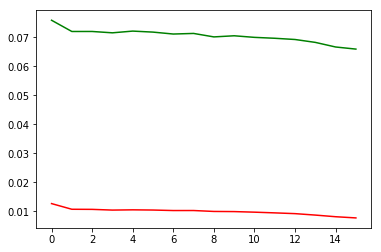

In [8]:
import numpy as np
import matplotlib.pyplot as plt

iters = range(len(history.history["loss"]))

plt.figure()
plt.plot(iters, history.history["loss"], color = 'red', label="train mse")
plt.plot(iters, history.history["mean_absolute_error"],color = 'green', label="train mae")
plt.show()


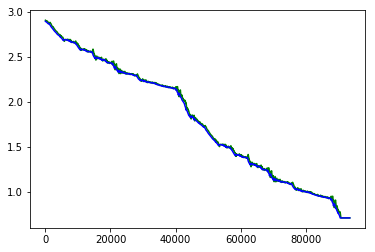

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x,color = 'green')
plt.plot(y,color = 'blue')
plt.show()

In [10]:

print("Test------------------------")
mse , mae = model.evaluate(x_test, y_test)
print("\ntest mae = %.8f% %"% (mae*100))
print("\ntest mse = %.8f% %"% (mse*100))


Test------------------------
9355/9355 [==============================] - 2s 197us/step

test mae = 7.28862646%

test mse = 0.54324328%


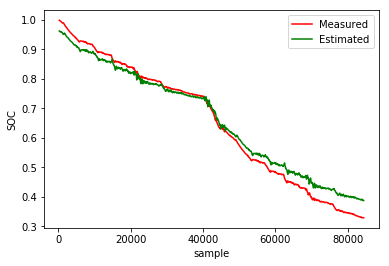

In [11]:
import scipy.io as spy
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, GRU, BatchNormalization
from keras.optimizers import Adam 
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

pred = model.predict(x_train, batch_size=16, verbose=0)

x_axix = range(TIME_STEP,TIME_STEP+pred.shape[0])
plt.plot(x_axix, y_train, color='red',label="Measured")
plt.plot(x_axix, pred, color='green',label="Estimated") 

plt.xlabel('sample')
plt.ylabel('SOC')
plt.legend()
plt.show()
